In [3]:
import pandas as pd
import requests
import zipfile
import numpy as np #working
import io
#This is me
#THIS CODE JUST LOADS DATA INTO df
# Download and load the dataset into one DataFrame
dfs = []
FILE_DOWNLOAD_URL = "http://cicresearch.ca/CICDataset/CIC-IDS-2017/Dataset/CIC-IDS-2017/CSVs/GeneratedLabelledFlows.zip"

response = requests.get(FILE_DOWNLOAD_URL)
with zipfile.ZipFile(io.BytesIO(response.content)) as z:
    for file in z.namelist()[1:]:  # skip the first entry if it's a folder
        with z.open(file) as f:
            dfs.append(pd.read_csv(f, encoding='cp1252'))

# Combine all CSVs into a single DataFrame
df = pd.concat(dfs, ignore_index=True)




ConnectionError: ('Connection aborted.', ConnectionResetError(104, 'Connection reset by peer'))

In [ ]:
!pip install shap lightgbm imbalanced-learn xgboost


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import shap

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    roc_curve, auc, precision_recall_curve, average_precision_score
)

from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier


In [ ]:
def preprocess_data(df, label_column=' Label'):
    # Separate features and label
    X = df.drop(columns=[label_column])
    y = df[label_column]

    # Keep numeric features
    X = X.select_dtypes(include=['number'])

    # Remove invalid values
    X.replace([np.inf, -np.inf], np.nan, inplace=True)
    X.dropna(inplace=True)
    y = y.loc[X.index]

    # Encode string labels (BENIGN, DDoS, ...)
    le = LabelEncoder()
    y_encoded = le.fit_transform(y)

    return X, y_encoded, le


In [ ]:
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)

    y_prob = model.predict_proba(X_test)

    print("==== Classification Report ====")
    print(classification_report(y_test, y_pred))

    print("==== Confusion Matrix ====")
    print(confusion_matrix(y_test, y_pred))

    # Only for binary classification
    if y_prob is not None and y_prob.shape[1] == 2:
        fpr, tpr, _ = roc_curve(y_test, y_prob[:, 1])
        roc_auc = auc(fpr, tpr)

        plt.figure()
        plt.plot(fpr, tpr, label=f'AUC={roc_auc:.3f}')
        plt.plot([0,1],[0,1],'k--')
        plt.title("ROC Curve")
        plt.legend()
        plt.show()

        precision, recall, _ = precision_recall_curve(y_test, y_prob[:, 1])
        pr_auc = average_precision_score(y_test, y_prob[:, 1])

        plt.figure()
        plt.plot(recall, precision, label=f'PR AUC={pr_auc:.3f}')
        plt.title("Precision-Recall Curve")
        plt.xlabel("Recall")
        plt.ylabel("Precision")
        plt.legend()
        plt.show()

    return y_pred


In [ ]:
def run_shap(model, X):
explainer = shap.TreeExplainer(model)
sample_size = min(2000, len(X))
X_sample = X.sample(sample_size, random_state=42)

shap_values = explainer.shap_values(X_sample)

shap.summary_plot(shap_values, X_sample, plot_type="bar", show=True)
shap.summary_plot(shap_values, X_sample, show=True)

In [2]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

def plot_multiclass_roc(model, X_test, y_test, class_names=None):
    # Predict probabilities
    y_score = model.predict_proba(X_test)

    n_classes = y_score.shape[1]

    # Binarize labels for multi-class ROC
    y_test_bin = label_binarize(y_test, classes=list(range(n_classes)))

    # Compute ROC curve and AUC per class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute ROC
    # -------------------------
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

    mean_tpr /= n_classes

    macro_auc = auc(all_fpr, mean_tpr)

    # Plot
    plt.figure(figsize=(8, 6))
    plt.plot(all_fpr, mean_tpr, label=f"Macro-average ROC (AUC = {macro_auc:.4f})", linewidth=2)

    plt.plot([0, 1], [0, 1], "k--", linewidth=0.8)
    plt.title("Multi-Class ROC Curve (Macro-Average)")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.grid(True)
    plt.show()

    print("\nPer-Class AUCs:")
    for i in range(n_classes):
        cname = class_names[i] if class_names is not None else f"Class {i}"
        print(f"{cname}: AUC = {roc_auc[i]:.4f}")

In [ ]:
def train_model(
        X, y,
        model=None,
        use_smote=True,
        test_size=0.2
    ):

    # Default model (XGBoost)
    if model is None:
        model = XGBClassifier(
            random_state=42,
            use_label_encoder=False,
            eval_metric='logloss'
        )

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=42, stratify=y
    )

    plot_multiclass_roc(reduced_model, X_test, y_test, class_names=label_encoder.classes_)

    # SMOTE
    if use_smote:
        print("Applying SMOTE...")
        sm = SMOTE(random_state=42)
        X_train, y_train = sm.fit_resample(X_train, y_train)

    # Train model
    model.fit(X_train, y_train)

    # Evaluation
    evaluate_model(model, X_test, y_test)

    # SHAP
    run_shap(model, X_train)

    return model


Applying SMOTE...


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [18:05:07] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


==== Classification Report ====
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    454265
           1       0.90      1.00      0.95       391
           2       1.00      1.00      1.00     25605
           3       1.00      1.00      1.00      2059
           4       1.00      1.00      1.00     46025
           5       0.99      0.99      0.99      1100
           6       1.00      1.00      1.00      1159
           7       1.00      1.00      1.00      1587
           8       1.00      1.00      1.00         2
           9       1.00      1.00      1.00         7
          10       1.00      1.00      1.00     31761
          11       1.00      1.00      1.00      1180
          12       0.87      0.84      0.85       301
          13       1.00      1.00      1.00         4
          14       0.62      0.75      0.68       130

    accuracy                           1.00    565576
   macro avg       0.96      0.97      0.96    5

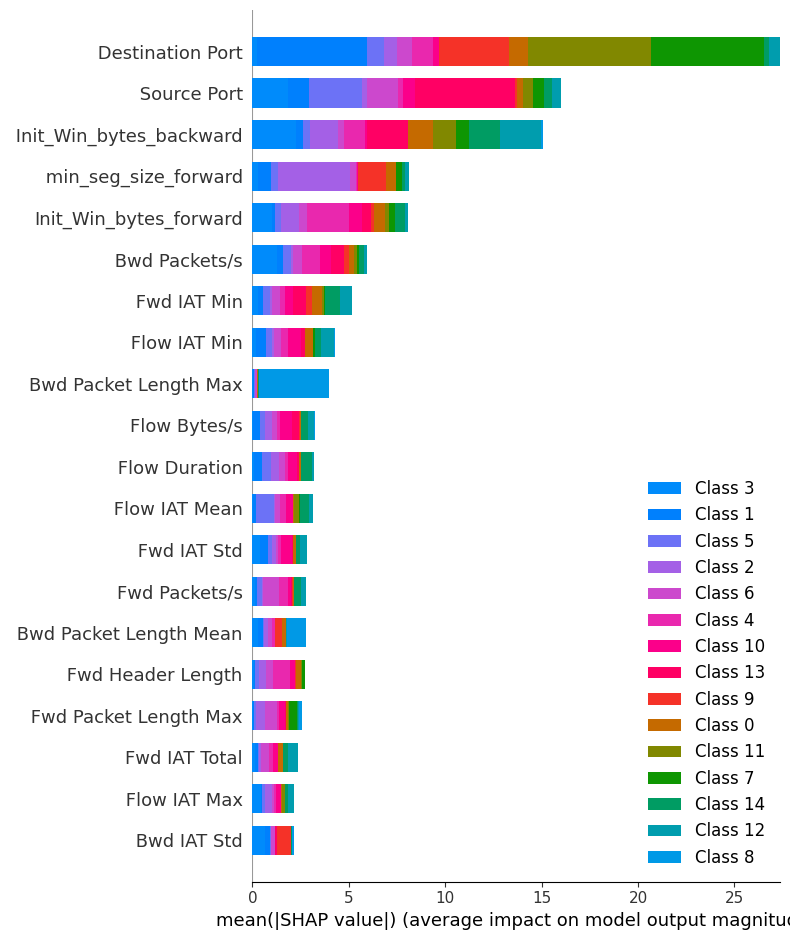

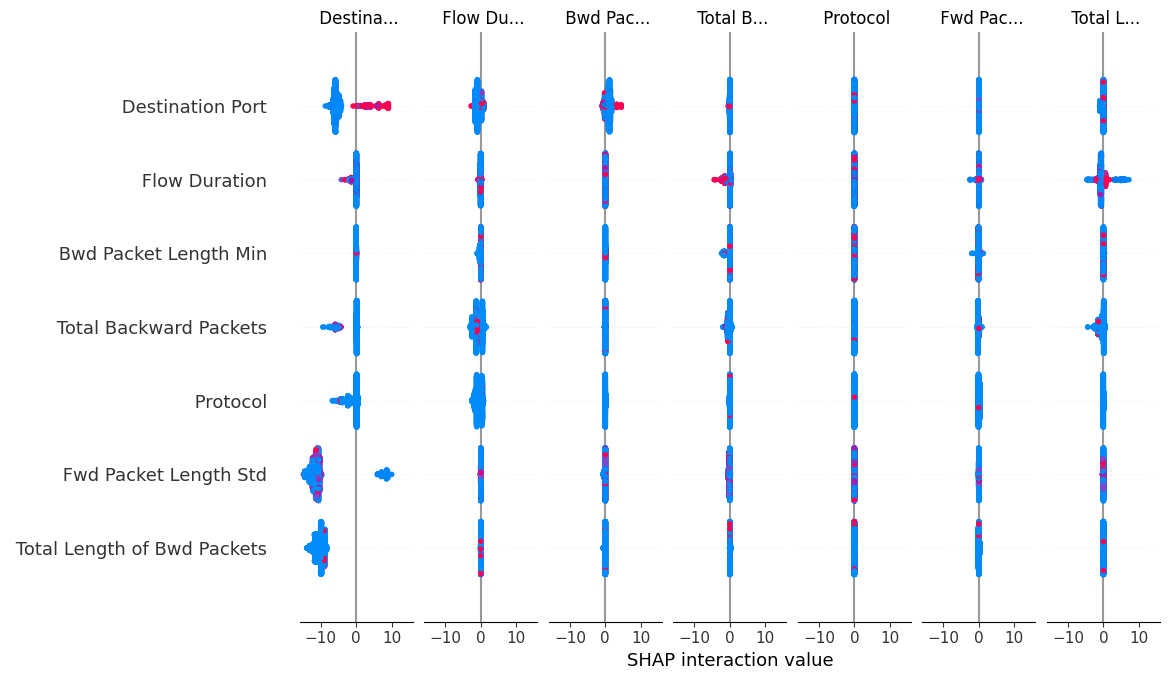

In [ ]:
X, y_encoded, label_encoder = preprocess_data(df)


model = train_model(X, y_encoded)

# With SMOTE
# model_smote = train_model(X, y_encoded, use_smote=True)



=== Training Baseline Model ===


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [22:45:25] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


==== Classification Report ====
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    454265
           1       0.96      0.98      0.97       391
           2       1.00      1.00      1.00     25605
           3       1.00      1.00      1.00      2059
           4       1.00      1.00      1.00     46025
           5       1.00      1.00      1.00      1100
           6       1.00      1.00      1.00      1159
           7       1.00      1.00      1.00      1587
           8       1.00      1.00      1.00         2
           9       1.00      0.57      0.73         7
          10       1.00      1.00      1.00     31761
          11       1.00      1.00      1.00      1180
          12       0.89      0.87      0.88       301
          13       1.00      0.50      0.67         4
          14       0.72      0.73      0.73       130

    accuracy                           1.00    565576
   macro avg       0.97      0.91      0.93    5

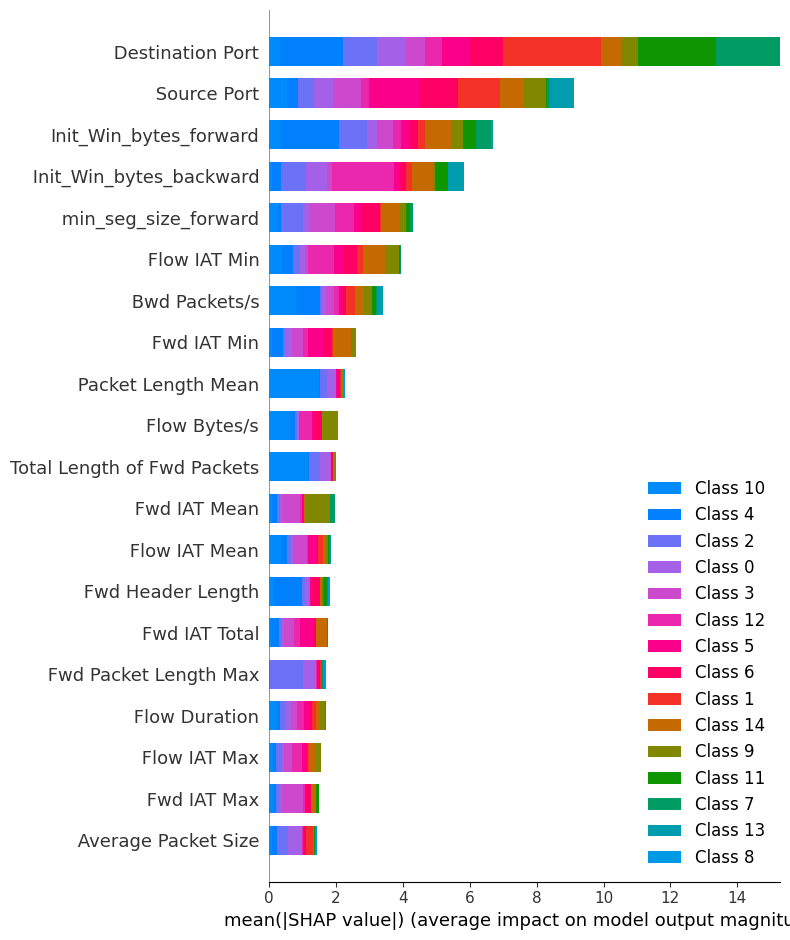

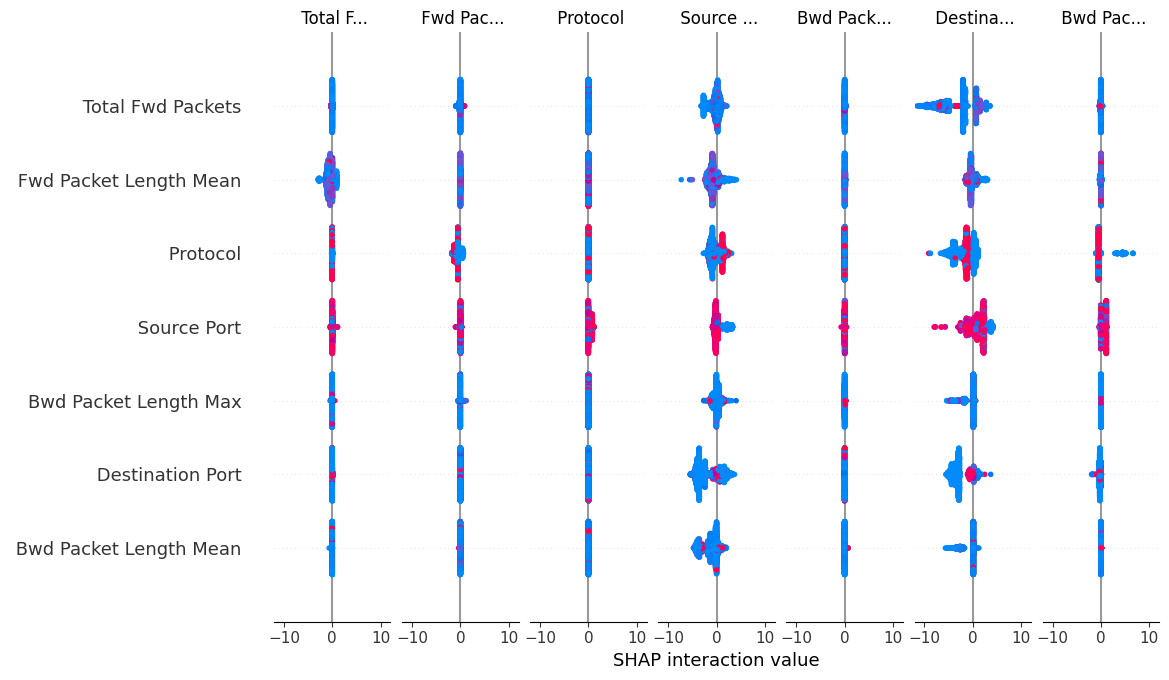

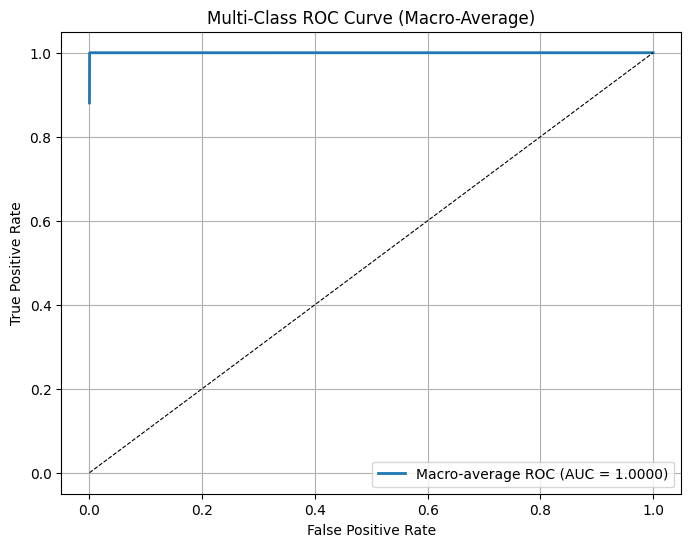


Per-Class AUCs:
BENIGN: AUC = 1.0000
Bot: AUC = 1.0000
DDoS: AUC = 1.0000
DoS GoldenEye: AUC = 1.0000
DoS Hulk: AUC = 1.0000
DoS Slowhttptest: AUC = 1.0000
DoS slowloris: AUC = 1.0000
FTP-Patator: AUC = 1.0000
Heartbleed: AUC = 1.0000
Infiltration: AUC = 1.0000
PortScan: AUC = 1.0000
SSH-Patator: AUC = 1.0000
Web Attack – Brute Force: AUC = 1.0000
Web Attack – Sql Injection: AUC = 1.0000
Web Attack – XSS: AUC = 1.0000

Baseline Accuracy: 0.9996

=== Computing SHAP Importances (sampled) ===
SHAP values type: <class 'numpy.ndarray'>
3D SHAP array detected: (2000, 80, 15)

Dropping bottom 40% (32) SHAP features:
 -  Bwd IAT Max
 -  Down/Up Ratio
 - Bwd Packet Length Max
 - Idle Mean
 -  Idle Max
 -  Protocol
 - Active Mean
 -  Active Max
 - Fwd PSH Flags
 -  Packet Length Variance
 -  Idle Std
 -  Active Std
 -  Bwd URG Flags
 -  SYN Flag Count
 -  Bwd PSH Flags
 -  Fwd URG Flags
 -  RST Flag Count
 - Bwd Avg Bulk Rate
 -  Bwd Avg Bytes/Bulk
 -  Bwd Avg Packets/Bulk
 -  Fwd Avg Packets/B

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [22:48:34] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


==== Classification Report ====
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    454265
           1       0.96      0.98      0.97       391
           2       1.00      1.00      1.00     25605
           3       1.00      1.00      1.00      2059
           4       1.00      1.00      1.00     46025
           5       1.00      1.00      1.00      1100
           6       1.00      1.00      1.00      1159
           7       1.00      1.00      1.00      1587
           8       1.00      1.00      1.00         2
           9       1.00      0.57      0.73         7
          10       1.00      1.00      1.00     31761
          11       1.00      1.00      1.00      1180
          12       0.88      0.87      0.87       301
          13       1.00      0.50      0.67         4
          14       0.70      0.72      0.71       130

    accuracy                           1.00    565576
   macro avg       0.97      0.91      0.93    5

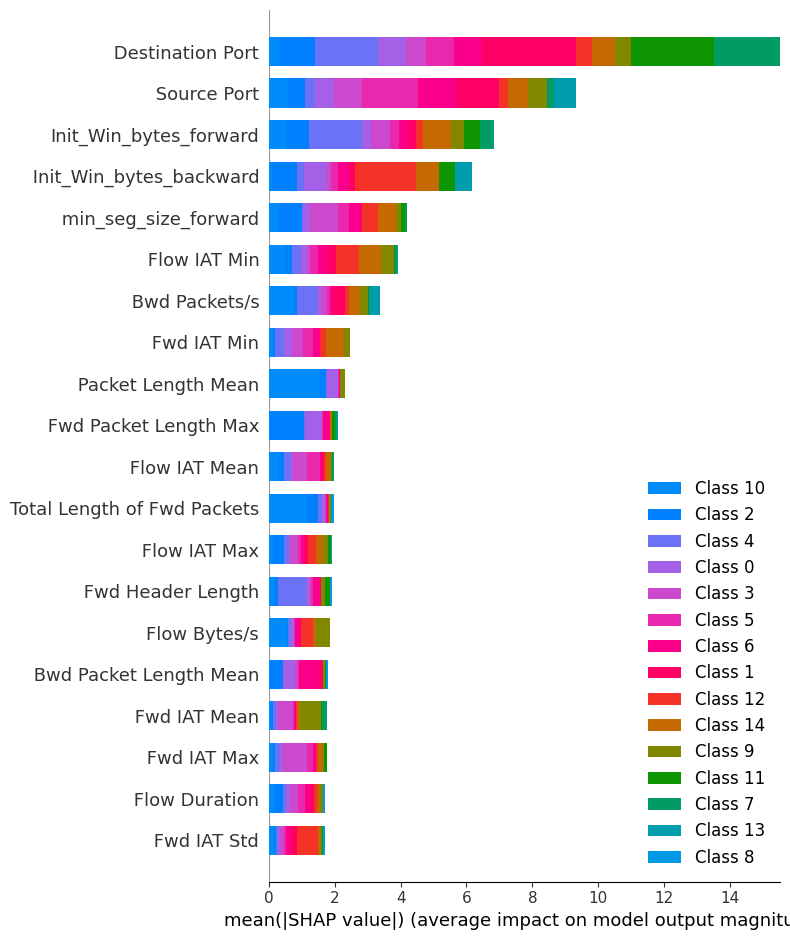

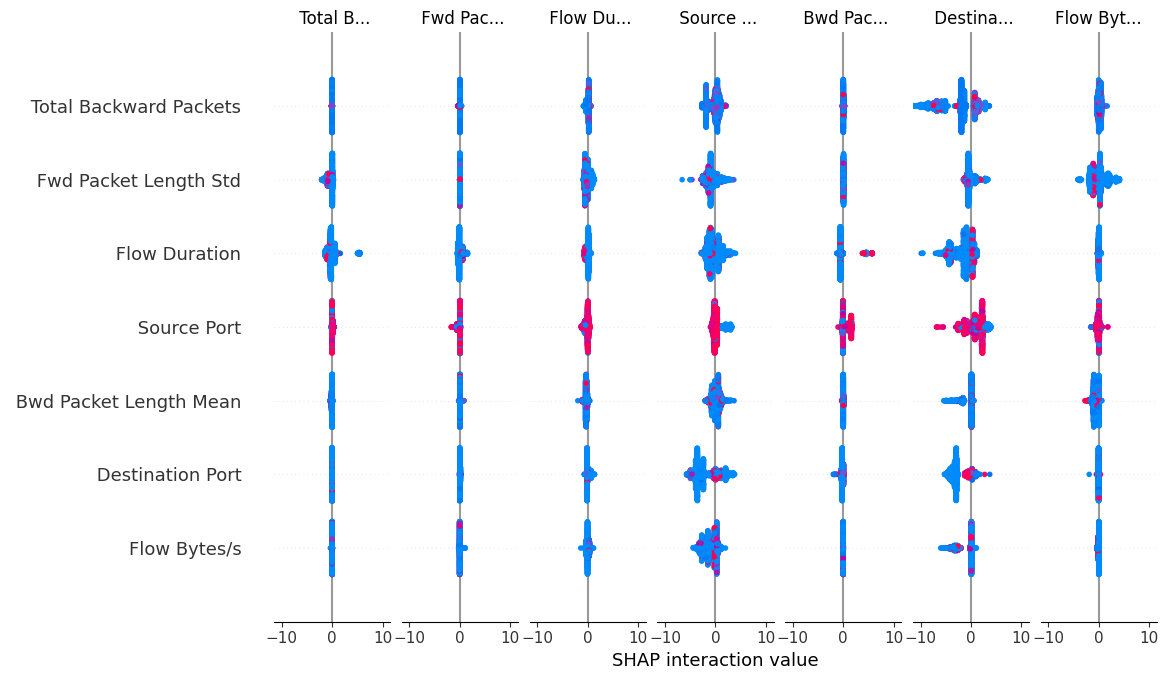

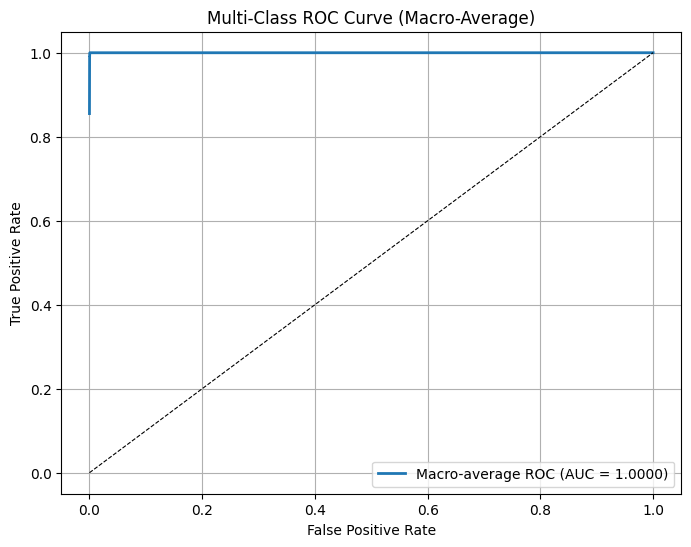


Per-Class AUCs:
BENIGN: AUC = 1.0000
Bot: AUC = 1.0000
DDoS: AUC = 1.0000
DoS GoldenEye: AUC = 1.0000
DoS Hulk: AUC = 1.0000
DoS Slowhttptest: AUC = 1.0000
DoS slowloris: AUC = 1.0000
FTP-Patator: AUC = 1.0000
Heartbleed: AUC = 1.0000
Infiltration: AUC = 1.0000
PortScan: AUC = 1.0000
SSH-Patator: AUC = 1.0000
Web Attack – Brute Force: AUC = 1.0000
Web Attack – Sql Injection: AUC = 1.0000
Web Attack – XSS: AUC = 1.0000

Reduced Accuracy: 0.9996

=== Performance Comparison Report ===
Baseline Accuracy: 0.9996
Reduced  Accuracy: 0.9996

⚠️ Performance DROPPED — consider keeping all features.


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

def shap_feature_reduction_and_retrain(
        X, y,
        base_model=None,
        drop_fraction=0.40,
        smote=False,
        shap_sample_size=2000
    ):

    print("\n=== Training Baseline Model ===")
    # Train baseline model without feature reduction
    baseline_model = train_model(X, y, model=base_model, use_smote=smote)

    # Baseline evaluation
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    baseline_pred = baseline_model.predict(X_test)
    baseline_acc = accuracy_score(y_test, baseline_pred)

    plot_multiclass_roc(baseline_model, X_test, y_test, class_names=label_encoder.classes_)

    print(f"\nBaseline Accuracy: {baseline_acc:.4f}")

    print("\n=== Computing SHAP Importances===")
    shap_sample_size = min(shap_sample_size, len(X_train))
    X_sample, _, y_sample, _ = train_test_split(
        X_train, y_train,
        train_size=shap_sample_size,
        stratify=y_train,
        random_state=42
    )

    explainer = shap.TreeExplainer(baseline_model)
    shap_values = explainer.shap_values(X_sample)

    # There was a shape issue this seems to fix
    shap_importance = np.ravel(shap_importance)

    # Build importance DataFrame
    importance_df = pd.DataFrame({
        "feature": X_sample.columns,
        "shap_importance": shap_importance
    }).sort_values("shap_importance", ascending=False)

    # Drop low importance features
    n_features = len(importance_df)
    n_drop = int(n_features * drop_fraction)
    to_drop = importance_df.tail(n_drop)["feature"].tolist()

    print(f"\nDropping lower {drop_fraction*100:.0f}% ({n_drop}) SHAP features:")
    for f in to_drop:
        print(" -", f)

    X_reduced = X.drop(columns=to_drop)
    print(f"\nReduced feature count: {X_reduced.shape[1]} (was {X.shape[1]})")

    # Retrain model with reduced feature set
    print("\n=== Training Reduced-Feature Model ===")
    reduced_model = train_model(X_reduced, y, model=base_model, use_smote=smote)

    # Evaluate reduced model
    X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(
        X_reduced, y, test_size=0.2, random_state=42, stratify=y
    )

    reduced_pred = reduced_model.predict(X_test_r)
    reduced_acc = accuracy_score(y_test_r, reduced_pred)

    plot_multiclass_roc(reduced_model, X_test_r, y_test_r, class_names=label_encoder.classes_)

    print(f"\nReduced Accuracy: {reduced_acc:.4f}")

    # Report comparison
    print("\n=== Performance Comparison Report ===")
    print(f"Baseline Accuracy: {baseline_acc:.4f}")
    print(f"Reduced  Accuracy: {reduced_acc:.4f}")

    if reduced_acc > baseline_acc:
        print("\n Performance IMPROVED")
    elif reduced_acc == baseline_acc:
        print("\n Performance UNCHANGED.")
    else:
        print("\n Performance DROPPED.")

    return {
        "baseline_accuracy": baseline_acc,
        "reduced_accuracy": reduced_acc,
        "dropped_features": to_drop,
        "importance_dataframe": importance_df,
        "baseline_model": baseline_model,
        "reduced_model": reduced_model
    }

results = shap_feature_reduction_and_retrain(X, y_encoded)
